In [1]:
import os

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

## 1. LLMChain

In [2]:
import pandas as pd

df = pd.read_csv('data/data.csv', delimiter="|")

In [3]:
df.head()

,Product,Review
0,Queen Size Sheet Set,I ordered a king size set. My only criticism w...
1,Waterproof Phone Pouch,"I loved the waterproof sac, although the openi..."
2,Pillows Insert,This is the best throw pillow fillers on Amazo...
3,Milk Frother Handheld,I loved this product. But they only seem to la...


In [4]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.chains import LLMChain

In [5]:
# '生成产品描述'
prompt = ChatPromptTemplate.from_template("What is the best name to describe a company that makes {product}?")

In [6]:
chat = ChatOpenAI(temperature=.9)

chain = LLMChain(llm=chat, prompt=prompt)

In [8]:
product = "Queen Size Sheet Set"
chain.run(product)

'"Royal Rest"'

## 2. Sequential chain

Sequential chain is another type of chains.

The idea if to combine ***multiple chains*** where ***the output of the one chain is the input of the next chain***.

Threre are two types of sequential chains:

1. SimpleSequentialChain: 一个连一个，上个链输出为下个链输入，整个链仅有一个输入和一个输出
2. SequentialChain: “网状链”，整个链仅有多个输入和多个输出

除此之外，还有一个路由链，***LLMRouterChain***，它可以**根据输入**<u>动态地</u>将提示路由到下游的链上。


### 2.1 SimpleSequentialChain

single input/output


In [9]:
from langchain.chains import SimpleSequentialChain

In [10]:
# prompt template #1
first_prompt = ChatPromptTemplate.from_template(
    "What is the best name to describe a company that makes {product}?")

# Chain #1
chain_one = LLMChain(llm=chat, prompt=first_prompt)

In [11]:
# prompt template #2
second_prompt = ChatPromptTemplate.from_template(
    "Write a 20 words description for the flowing company: {company_name}")

# Chain #2
chain_two = LLMChain(llm=chat, prompt=second_prompt)

In [12]:
# combine two chains into one simple chain
overall_simple_chain = SimpleSequentialChain(chains=[chain_one, chain_two], verbose=True)

product = "Queen Size Sheet Set"
overall_simple_chain.run(product)



> Entering new SimpleSequentialChain chain...
RegalRest
RegalRest is a luxury bedding company that offers premium, comfortable and stylish sleep solutions for a truly regal experience.

> Finished chain.


'RegalRest is a luxury bedding company that offers premium, comfortable and stylish sleep solutions for a truly regal experience.'

### 2.2 SequentialChain

with multiple inputs/outputs


In [20]:
from langchain.chains import SequentialChain

In [28]:
# prompt template 1: translate to english
first_prompt = ChatPromptTemplate.from_template(
    "Translate the following review to english:"
    "\n\n{Review}"
)
# chain 1: input= Review and output= English_Review
chain_one = LLMChain(llm=chat, prompt=first_prompt, 
                     output_key="English_Review"
                    )

In [29]:
second_prompt = ChatPromptTemplate.from_template(
    "Can you summarize the following review in 1 sentence:"
    "\n\n{English_Review}"
)
# chain 2: input= English_Review and output= summary
chain_two = LLMChain(llm=chat, prompt=second_prompt, 
                     output_key="summary"
                    )

In [30]:
# prompt template 3: translate to english
third_prompt = ChatPromptTemplate.from_template(
    "What language is the following review:\n\n{Review}"
)
# chain 3: input= Review and output= language
chain_three = LLMChain(llm=chat, prompt=third_prompt,
                       output_key="language"
                      )

In [31]:
# prompt template 4: follow up message
fourth_prompt = ChatPromptTemplate.from_template(
    "Write a follow up response to the following "
    "summary in the specified language:"
    "\n\nSummary: {summary}\n\nLanguage: {language}"
)
# chain 4: input= summary, language and output= followup_message
chain_four = LLMChain(llm=chat, prompt=fourth_prompt,
                      output_key="followup_message"
                     )

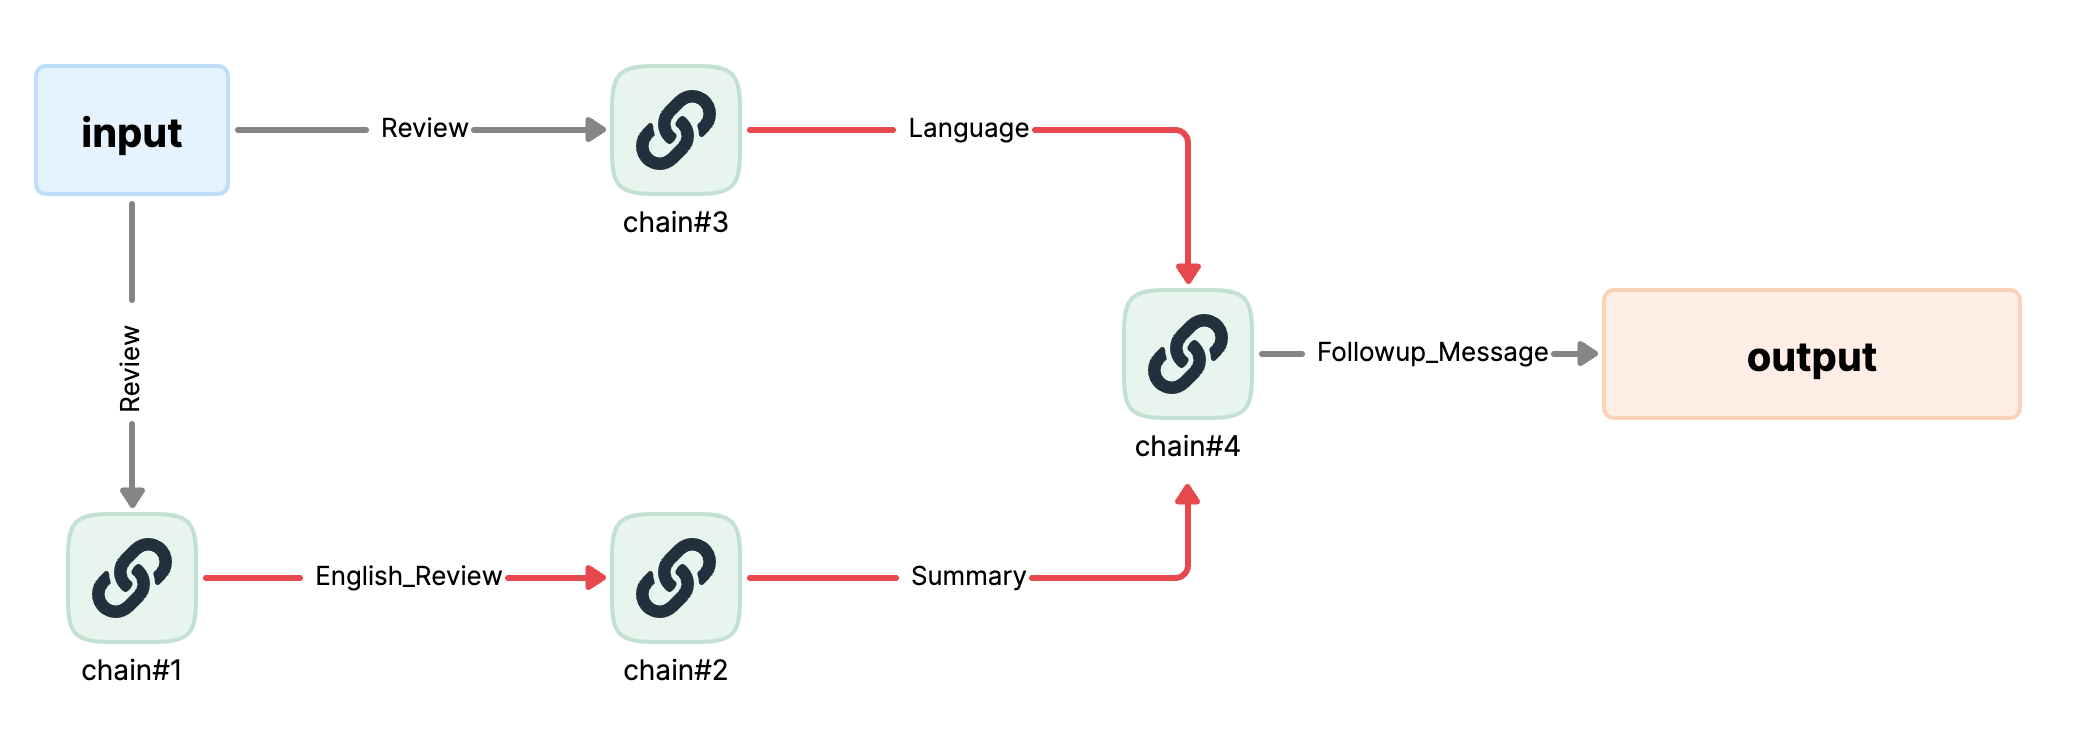

In [33]:
# overall_chain: input= Review 
# and output= English_Review,summary, followup_message
overall_chain = SequentialChain(
    chains=[chain_one, chain_two, chain_three, chain_four],
    input_variables=["Review"],
    output_variables=["English_Review", "summary","followup_message"],
    verbose=True
)

In [35]:
#overall_chain('Está lu bonita calienta muy rápido, es muy funcional, solo falta ver cuánto dura, solo llevo 3 días en funcionamiento.')
overall_chain('今天早晨我如常起床，早餐做了煎蛋、香肠和全麦面包，工作到中午。午餐在餐馆吃了意大利面。下午去图书馆借了两本书。回家做了运动，晚餐吃了三明治和蔬菜汤。睡前看了会儿书，然后就睡了，今天过得很充实。')



> Entering new SequentialChain chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-fGiXRt9ovlGsNkfpE6yz98o3 on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-fGiXRt9ovlGsNkfpE6yz98o3 on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht


> Finished chain.


{'Review': '今天早晨我如常起床，早餐做了煎蛋、香肠和全麦面包，工作到中午。午餐在餐馆吃了意大利面。下午去图书馆借了两本书。回家做了运动，晚餐吃了三明治和蔬菜汤。睡前看了会儿书，然后就睡了，今天过得很充实。',
 'English_Review': 'This morning I woke up as usual and made fried eggs, sausages, and whole wheat bread for breakfast. I worked until noon. I had spaghetti for lunch at a restaurant. In the afternoon, I went to the library and borrowed two books. I exercised when I got home and had a sandwich and vegetable soup for dinner. I read for a while before bed and then went to sleep. Today was fulfilling.',
 'summary': 'The reviewer had a productive day that included cooking breakfast, working, enjoying lunch at a restaurant, visiting the library, exercising, having dinner, and reading before bed, resulting in a fulfilling day overall.',
 'followup_message': '回复：\n谢谢你分享你充实而愉快的一天！你的日程安排听起来非常令人羡慕。早餐自己做还是去餐馆享用呢？有没有特别喜欢的食物呢？能不能告诉我你去的图书馆是哪个地方呢？我也喜欢运动，你是怎么锻炼的呢？晚餐有没有尝试新的菜品？最后，在床前阅读是个很好的习惯。你在读什么书呢？期待听到你更多关于你充实的一天的故事！'}

## 2.3 路由链

路由链会***根据输入的内容***将指定内容路由到不同的链中。

比如，如果你有多个子链，每个子链专门处理特定类型的输入，你可以使用一个路由链，他首先会决定将输入传递给哪个子链，然后将其传递给该链。

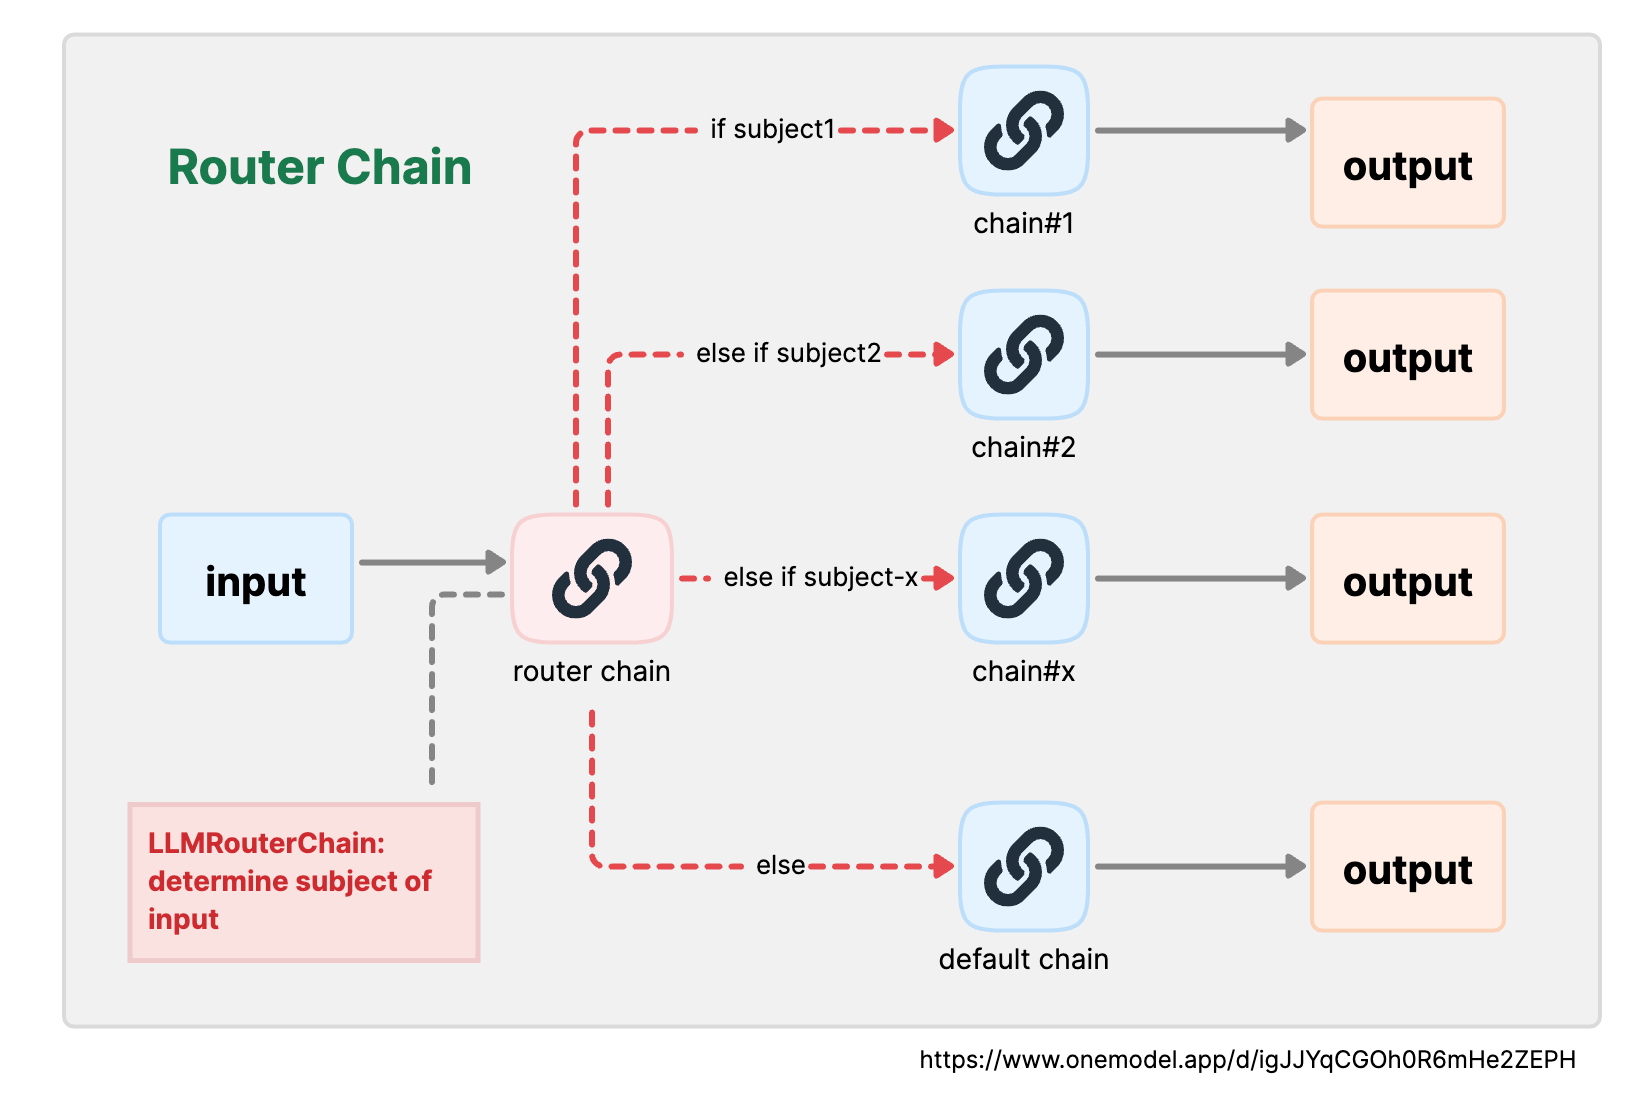


In [36]:
physics_template = """You are a very smart physics professor. \
You are great at answering questions about physics in a concise\
and easy to understand manner. \
When you don't know the answer to a question you admit\
that you don't know.

Here is a question:
{input}"""

math_template = """You are a very good mathematician. \
You are great at answering math questions. \
You are so good because you are able to break down \
hard problems into their component parts, 
answer the component parts, and then put them together\
to answer the broader question.

Here is a question:
{input}"""

history_template = """You are a very good historian. \
You have an excellent knowledge of and understanding of people,\
events and contexts from a range of historical periods. \
You have the ability to think, reflect, debate, discuss and \
evaluate the past. You have a respect for historical evidence\
and the ability to make use of it to support your explanations \
and judgements.

Here is a question:
{input}"""

computerscience_template = """ You are a successful computer scientist.\
You have a passion for creativity, collaboration,\
forward-thinking, confidence, strong problem-solving capabilities,\
understanding of theories and algorithms, and excellent communication \
skills. You are great at answering coding questions. \
You are so good because you know how to solve a problem by \
describing the solution in imperative steps \
that a machine can easily interpret and you know how to \
choose a solution that has a good balance between \
time complexity and space complexity. 

Here is a question:
{input}"""

In [37]:
# 5 prompt template infos of physics,math,history,computerscience,biology
prompt_infos = [
    {
        "name": "physics", 
        "description": "Good for answering questions about physics", 
        "prompt_template": physics_template
    },
    {
        "name": "math", 
        "description": "Good for answering math questions", 
        "prompt_template": math_template
    },
    {
        "name": "History", 
        "description": "Good for answering history questions", 
        "prompt_template": history_template
    },
    {
        "name": "computer science", 
        "description": "Good for answering computer science questions", 
        "prompt_template": computerscience_template
    },
    {
        "name": "biology", 
        "description": "Good for answering biology questions", 
        "prompt_template": computerscience_template
    }
]

In [38]:
from langchain.chains.router import MultiPromptChain
from langchain.chains.router.llm_router import LLMRouterChain,RouterOutputParser
from langchain.prompts import PromptTemplate

In [39]:
# create destination chains
destination_chains = {}
for p_info in prompt_infos:
    name = p_info["name"]
    prompt_template = p_info["prompt_template"]
    prompt = ChatPromptTemplate.from_template(template=prompt_template)
    chain = LLMChain(llm=chat, prompt=prompt)
    destination_chains[name] = chain  
    
destinations = [f"{p['name']}: {p['description']}" for p in prompt_infos]
destinations_str = "\n".join(destinations)

In [40]:
print(destination_chains.keys())

destinations

dict_keys(['physics', 'math', 'History', 'computer science', 'biology'])


['physics: Good for answering questions about physics',
 'math: Good for answering math questions',
 'History: Good for answering history questions',
 'computer science: Good for answering computer science questions',
 'biology: Good for answering biology questions']

In [41]:
default_prompt = ChatPromptTemplate.from_template("{input}")
# 默认的 chain（未命中已定义的五种chain时使用默认chain）
default_chain = LLMChain(llm=chat, prompt=default_prompt)

In [42]:
# 进行链路由时使用的提示模板
MULTI_PROMPT_ROUTER_TEMPLATE = """Given a raw text input to a \
language model select the model prompt best suited for the input. \
You will be given the names of the available prompts and a \
description of what the prompt is best suited for. \
You may also revise the original input if you think that revising\
it will ultimately lead to a better response from the language model.

<< FORMATTING >>
Return a markdown code snippet with a JSON object formatted to look like:
```json
{{{{
    "destination": string \ name of the prompt to use or "DEFAULT"
    "next_inputs": string \ a potentially modified version of the original input
}}}}
```

REMEMBER: "destination" MUST be one of the candidate prompt names specified below OR it can be "DEFAULT" if the input is not
well suited for any of the candidate prompts. 
REMEMBER: "next_inputs" can just be the original input if you don't think any modifications are needed.

<< CANDIDATE PROMPTS >> 
{destinations}

<< INPUT >> 
{{input}}

<< OUTPUT (remember to include the ```json)>>
"""

In [43]:
router_template = MULTI_PROMPT_ROUTER_TEMPLATE.format(
    destinations=destinations_str
)
router_prompt = PromptTemplate(
    template=router_template,
    input_variables=["input"],
    output_parser=RouterOutputParser(),
)

# create router chain
router_chain = LLMRouterChain.from_llm(chat, router_prompt)

In [44]:
# create MultiPromptChain
chain = MultiPromptChain(router_chain=router_chain, 
                         destination_chains=destination_chains, 
                         default_chain=default_chain,
                         verbose=True)

In [45]:
print(chain.run("What is black body radiation?"))



> Entering new MultiPromptChain chain...


/Users/engure/Library/Python/3.9/lib/python/site-packages/langchain/chains/llm.py:278: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


physics: {'input': 'What is black body radiation?'}

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-fGiXRt9ovlGsNkfpE6yz98o3 on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-fGiXRt9ovlGsNkfpE6yz98o3 on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht


> Finished chain.
Black body radiation refers to the electromagnetic radiation emitted by an object that absorbs all incident radiation without reflecting or transmitting any. In simpler terms, a black body is an idealized object that absorbs all light and emits radiation across a wide range of frequencies and wavelengths. The radiation emitted by a black body, known as black body radiation, follows a specific pattern called Planck's law, which describes how the intensity of radiation varies with frequency or wavelength at a given temperature. This phenomenon is important in understanding various areas of physics, such as thermal radiation and the behavior of objects at high temperatures.


In [46]:
print(chain.run("what is 2 + 2"))



> Entering new MultiPromptChain chain...


Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-fGiXRt9ovlGsNkfpE6yz98o3 on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..


math: {'input': 'what is 2 + 2'}

Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-fGiXRt9ovlGsNkfpE6yz98o3 on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit https://platform.openai.com/account/billing to add a payment method..
Retrying langchain.chat_models.openai.ChatOpenAI.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-gpt-3.5-turbo in organization org-fGiXRt9ovlGsNkfpE6yz98o3 on requests per min. Limit: 3 / min. Please try again in 20s. Contact us through our help center at help.openai.com if you continue to have issues. Please add a payment method to your account to increase your rate limit. Visit ht


> Finished chain.
Thank you for your compliment! As a mathematician, I can definitely help you with your math questions. 

The problem you provided is a simple addition problem. To solve it, we need to add the numbers 2 and 2 together. 

2 + 2 equals 4. 

So, the answer to the question "what is 2 + 2?" is 4.


In [50]:
print(chain.run("Why does every cell in our body contain DNA?"))



> Entering new MultiPromptChain chain...
biology: {'input': 'Why is DNA present in every cell of our body?'}
> Finished chain.
DNA is present in every cell of our body because it serves as the genetic blueprint for life. DNA, or deoxyribonucleic acid, contains the instructions necessary for an organism's growth, development, functioning, and reproduction.

Each cell in our body requires a set of instructions to perform its specific function, and DNA provides these instructions. It carries the information needed to build and maintain the intricate network of proteins that are responsible for the structure and function of cells.

Additionally, DNA holds the code for the production of enzymes, which enable the chemical reactions necessary for various cellular processes. It also contains the information required for cell division and replication, allowing our bodies to grow and repair damaged tissues.

Since all cells in our body are derived from a single fertilized egg, they carry the s